# Setting

---
Họ và tên: Nguyễn Văn Chức

Prototype: Origin 


Structure: 
$$ Checkerboard \times 4   \rightarrow Squeeze \rightarrow Channelwise\times 3 \rightarrow Unsqueeze \rightarrow Checkerbaord \times 3$$



In [ ]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as  plt
from tqdm import trange, tqdm, notebook
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable 
from torchvision.utils import save_image, make_grid
import IPython
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device



device(type='cuda')

In [ ]:
!nvidia-smi

Fri Nov 27 18:41:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    12W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Util Function

In [ ]:
def get_data(include_labels=False):
    fname = "/content/drive/My Drive/pytorch tutorial/celeb.pkl"
    with open(fname, 'rb') as f:
        data = pickle.load(f)
 
    train_data, test_data = data['train'], data['test']
    
    train_data = train_data[:10000, :, :, [2, 1, 0]] # take 10000 train
    test_data = test_data[:3000, :, :, [2, 1, 0]] #take 6000 test
    return train_data, test_data

# Build Model

In [ ]:
class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0, bias= True):
        super(WeightNormConv2d, self).__init__()
        self.conv= nn.utils.weight_norm(
            nn.Conv2d(in_dim, out_dim, kernel_size,
                      stride=stride, padding=padding, bias=bias)
        )
 
    def forward(self,x):
        return self.conv(x)

In [ ]:
class ActNorm(nn.Module):
    def __init__(self, n_channels):
        super(ActNorm, self).__init__()
        self.log_scale = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.shift = nn.Parameter(torch.zeros(1, n_channels, 1, 1), requires_grad=True)
        self.n_channels = n_channels
        self.initialized = False
 
    def forward(self, x, reverse=False):
        if reverse:
            return (x - self.shift) * torch.exp(-self.log_scale), self.log_scale
        else:
            if not self.initialized:
                self.shift.data = -torch.mean(x, dim=[0, 2, 3], keepdim=True)
                self.log_scale.data = - torch.log(
                    torch.std(x.permute(1, 0, 2, 3).reshape(self.n_channels, -1), dim=1).reshape(1, self.n_channels, 1,
                                                                                                 1))
                self.initialized = True
                result = x * torch.exp(self.log_scale) + self.shift
            return x * torch.exp(self.log_scale) + self.shift, self.log_scale

In [ ]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.block = nn.Sequential(
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1),
            nn.ReLU(),
            WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0))
 
    def forward(self, x):
        return x + self.block(x)

In [ ]:
class SimpleResnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=6, n_filters=128, n_blocks=8):
        super(SimpleResnet, self).__init__()
        layers = [WeightNormConv2d(in_channels, n_filters, (3, 3), stride=1, padding=1),
                  nn.ReLU()]
        for _ in range(n_blocks):
            layers.append(ResnetBlock(n_filters))
        layers.append(nn.ReLU())
        layers.append(WeightNormConv2d(n_filters, out_channels, (3, 3), stride=1, padding=1))
        self.resnet = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.resnet(x)

In [ ]:
class AffineCheckerboardTransform(nn.Module):
    def __init__(self, type=1.0):
        super(AffineCheckerboardTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet()
 
    def build_mask(self, type=1.0):
        # if type == 1.0, the top left corner will be 1.0
        # if type == 0.0, the top left corner will be 0.0
        mask = np.arange(32).reshape(-1, 1) + np.arange(32)
        mask = np.mod(type + mask, 2)
        mask = mask.reshape(-1, 1, 32, 32)
        return torch.tensor(mask.astype('float32')).to(device) 
 
    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask
 
        log_s, t = self.resnet(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)
 
        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

In [ ]:
class AffineHalfHalfTransform(nn.Module):
    def __init__(self, type):
        super(AffineHalfHalfTransform, self).__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet()

    def build_mask(self, type):
        # if type == "top", the top half is 1s
        # if type == "bottom", the bottom half is 1s
        # if type == "left", left half is 1s
        # if type == right", right half is 1s
        assert type in {"top", "bottom", "left", "right"}
        if type == "bottom":
            mask = np.concatenate([np.zeros([1, 1, 16, 32]), np.ones([1, 1, 16, 32])], axis=2)
        elif type == "top":
            mask = np.concatenate([np.ones([1, 1, 16, 32]), np.zeros([1, 1, 16, 32])], axis=2)
        elif type == "left":
            mask = np.concatenate([np.ones([1, 1, 32, 16]), np.zeros([1, 1, 32, 16])], axis=3)
        elif type == "right":
            mask = np.concatenate([np.zeros([1, 1, 32, 16]), np.ones([1, 1, 32, 16])], axis=3)
        else:
            raise NotImplementedError
        return torch.tensor(mask.astype('float32')).to(device)

    def forward(self, x, reverse=False):
        # returns transform(x), log_det
        batch_size, n_channels, _, _ = x.shape
        mask = self.mask.repeat(batch_size, 1, 1, 1)
        x_ = x * mask

        log_s, t = self.resnet(x_).split(n_channels, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
        t = t * (1.0 - mask)
        log_s = log_s * (1.0 - mask)

        if reverse:  # inverting the transformation
            x = (x - t) * torch.exp(-log_s)
        else:
            x = x * torch.exp(log_s) + t
        return x, log_s

In [ ]:
class AffineChannelTransform(nn.Module):
    def __init__(self, modify_top):
        super(AffineChannelTransform, self).__init__()
        self.modify_top = modify_top
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.resnet = SimpleResnet(in_channels=6, out_channels=12)
 
    def forward(self, x, reverse=False):
        n_channels = x.shape[1]
        if self.modify_top:
            on, off = x.split(n_channels // 2, dim=1)
        else:
            off, on = x.split(n_channels // 2, dim=1)
        log_s, t = self.resnet(off).split(n_channels // 2, dim=1)
        log_s = self.scale * torch.tanh(log_s) + self.scale_shift
 
        if reverse:  # inverting the transformation
            on = (on - t) * torch.exp(-log_s)
        else:
            on = on * torch.exp(log_s) + t
 
        if self.modify_top:
            return torch.cat([on, off], dim=1), torch.cat([log_s, torch.zeros_like(log_s)], dim=1)
        else:
            return torch.cat([off, on], dim=1), torch.cat([torch.zeros_like(log_s), log_s], dim=1)

In [ ]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
 
        self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        # self.prior = torch.distributions.Normal(torch.tensor(0.).to(device), torch.tensor(1.).to(device))
        self.checker_transforms1 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0)
        ])
 
        self.channel_transforms = nn.ModuleList([
            AffineChannelTransform(True),
            ActNorm(12),
            AffineChannelTransform(False),
            ActNorm(12),
            AffineChannelTransform(True)
        ])
 
        self.checker_transforms2 = nn.ModuleList([
            AffineCheckerboardTransform(1.0),
            ActNorm(3),
            AffineCheckerboardTransform(0.0),
            ActNorm(3),
            AffineCheckerboardTransform(1.0)
        ])
 
    def squeeze(self, x):
        # C x H x W -> 4C x H/2 x W/2
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
        return x
 
    def undo_squeeze(self, x):
        #  4C x H/2 x W/2  ->  C x H x W
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
        return x
 
    def g(self, z):
        # z -> x (inverse of f)
        x = z
        for op in reversed(self.checker_transforms2):
            x, _ = op.forward(x, reverse=True)
        x = self.squeeze(x)
        for op in reversed(self.channel_transforms):
            x, _ = op.forward(x, reverse=True)
        x = self.undo_squeeze(x)
        for op in reversed(self.checker_transforms1):
            x, _ = op.forward(x, reverse=True)
        return x
 
    def f(self, x):
        # maps x -> z, and returns the log determinant (not reduced)
        z, log_det = x, torch.zeros_like(x)
        for op in self.checker_transforms1:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        z, log_det = self.squeeze(z), self.squeeze(log_det)
        for op in self.channel_transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        z, log_det = self.undo_squeeze(z), self.undo_squeeze(log_det)
        for op in self.checker_transforms2:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det
 
    def log_prob(self, x):
        z, log_det = self.f(x)
        return torch.sum(log_det, [1, 2, 3]) + torch.sum(self.prior.log_prob(z), [1, 2, 3])
 
    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 3, 32, 32])
        return self.g(z)

# Train and Test model


In [ ]:
class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.log_interval = 100
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)
        self.dir="/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/mask_1/"
 
    def build(self):
        self.flow = RealNVP().to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)
 
    def create_loaders(self):
        train, test = get_data()
        train = np.transpose(train, axes=[0, 3, 1, 2])  # NCHW 20000 x 3 x 32 x 32
        test = np.transpose(test, axes=[0, 3, 1, 2])  # NCHW 6838 x 3 x 32 x 32
        train_loader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=False, pin_memory=False)
        test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, pin_memory=False)
        return train_loader, test_loader
 
    def preprocess(self, x, reverse=False, dequantize=True):
        if reverse:  # doesn't map back to [0, 4]
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            # dequantization
            if dequantize:
                x += torch.distributions.Uniform(0.0, 1.0).sample(x.shape).to(device)
            x /= 4.0
 
            # logit operation
            x *= 0.9
            x += 0.05
            logit = torch.log(x) - torch.log(1.0 - x)
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(4.0))
            return logit, torch.sum(log_det, dim=(1, 2, 3))
 
    def train(self):     
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1
 
            self.flow.train()
            self.batch_loss_history = []
 
            for batch_i, image in enumerate(notebook.tqdm(
                    self.train_loader, desc='Batch', leave=False)):
 
                batch_i += 1
                # [batch_size, 3, 32, 32]
                image = Variable(image).to(device)
                logit_x, log_det = self.preprocess(image.float())
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det
 
                batch_loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0)
 
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
 
                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)
 
            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')
 
            train_losses.append(epoch_loss)
            val_losses.append(self.get_loss(self.val_loader))
            np.save(self.dir + "train_losses_mask1.npy", np.array(train_losses))
            np.save(self.dir + "val_losses_mask1.npy", np.array(val_losses))
        
        self.save_model(self.dir + "realnvp_final_mask1.model")
        return train_losses, val_losses
 
    def get_loss(self, loader):
        """Compute error on provided data set"""
        errors = []
        # cuda.synchronize()
        start = time.time()
 
        self.flow.eval()
 
        for image in loader:
            with torch.no_grad():
                image = image.to(device)
                logit_x, log_det = self.preprocess(image.float())
                log_prob = self.flow.log_prob(logit_x)
                log_prob += log_det
 
                loss = -torch.mean(log_prob) / (3.0 * 32.0 * 32.0)
                error = float(loss.data)
                errors.append(error)
 
        # cuda.synchronize()
        time_test = time.time() - start
        log_string = f'Calc done! | It took {time_test:.1f}s | '
        log_string += f'Loss: {np.mean(errors):.2f}'
        tqdm.write(log_string)
        return np.mean(errors)
 
    def sample(self, num_samples):
        with torch.no_grad():
            raw_samples = self.flow.sample(num_samples).cpu()
            samples = self.preprocess(raw_samples, reverse=True)
            return samples.cpu().numpy()
 
    def save_model(self, filename):
        torch.save(self.flow, filename)
 
    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

Epoch 1 Loss: 0.88
Calc done! | It took 19.0s | Loss: 0.73


Epoch 2 Loss: 0.71
Calc done! | It took 18.9s | Loss: 0.69


Epoch 3 Loss: 0.68
Calc done! | It took 18.9s | Loss: 0.67


Epoch 4 Loss: 0.66
Calc done! | It took 18.8s | Loss: 0.65


Epoch 5 Loss: 0.64
Calc done! | It took 18.8s | Loss: 0.64


Epoch 6 Loss: 0.63
Calc done! | It took 18.8s | Loss: 0.63


Epoch 7 Loss: 0.62
Calc done! | It took 18.8s | Loss: 0.62


Epoch 8 Loss: 0.62
Calc done! | It took 18.9s | Loss: 0.61


Epoch 9 Loss: 0.61
Calc done! | It took 18.8s | Loss: 0.61


Epoch 10 Loss: 0.60
Calc done! | It took 18.9s | Loss: 0.61


Epoch 11 Loss: 0.60
Calc done! | It took 18.8s | Loss: 0.60


Epoch 12 Loss: 0.59
Calc done! | It took 18.8s | Loss: 0.59


Epoch 13 Loss: 0.59
Calc done! | It took 18.8s | Loss: 0.59


Epoch 14 Loss: 0.59
Calc done! | It took 18.9s | Loss: 0.58


Epoch 15 Loss: 0.58
Calc done! | It took 18.9s | Loss: 0.58


Epoch 16 Loss: 0.58
Calc done! | It took 18.8s | Loss: 0.58


Epoch 17 Loss: 0.58
Calc done! | It took 18.8s | Loss: 0.57


Epoch 18 Loss: 0.57
Calc done! | It took 18.9s | Loss: 0.57


Epoch 19 Loss: 0.57
Calc done! | It took 18.8s | Loss: 0.57


Epoch 20 Loss: 0.57
Calc done! | It took 18.8s | Loss: 0.57


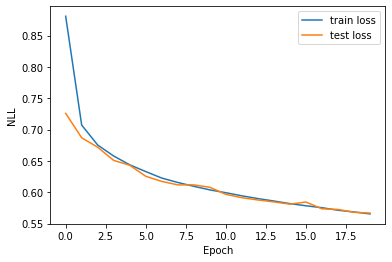

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


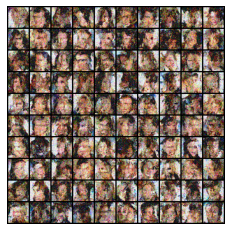

In [ ]:
#def run():
 
dir="/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/"
 
solver = Solver(n_epochs=20)
solver.build()
train_losses, test_losses= solver.train()
plt.figure()
n_epochs = len(test_losses) - 1
x_train = np.linspace(0, n_epochs, len(train_losses))
x_test = np.arange(n_epochs + 1)
 
plt.plot(x_train, train_losses, label='train loss')
plt.plot(x_test, test_losses, label='test loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.savefig(dir + "eval_model.png")
plt.show()
plt.close()
 
samples = np.transpose(solver.sample(100), axes=[0, 2, 3, 1])
samples = samples.astype('float')
samples = samples *255.0
samples = (torch.FloatTensor(samples) / 255).permute(0, 3, 1, 2)
grid_img = make_grid(samples, nrow=10)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
plt.savefig( dir+ "sample_model.png")
plt.axis('off')
plt.show()
 


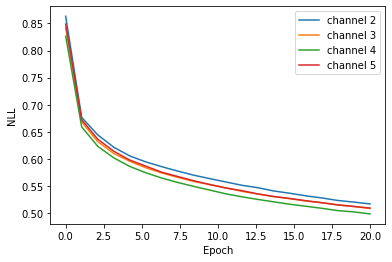

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
train_losses2 = np.load("/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/channel_2/train_losses_chan2.npy")
train_losses3 = np.load("/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/channel_3/train_losses_chan3.npy")
train_losses4 = np.load("/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/channel_4/train_lossesa_chan4.npy")
train_losses5 = np.load("/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/channel_5/train_losses_chan5.npy")

x_train = np.linspace(0, 20, len(train_losses2))
plt.figure()
plt.plot(x_train, train_losses2, label='channel 2')
plt.plot(x_train, train_losses3, label='channel 3')
plt.plot(x_train, train_losses4, label='channel 4')
plt.plot(x_train, train_losses5, label='channel 5')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('NLL')

plt.savefig("/content/drive/MyDrive/pytorch tutorial/Result_RealNVP/channel_compare.png")
plt.show()


In [10]:
!git push origin master

error: src refspec master does not match any.
error: failed to push some refs to 'https://github.com/chucgohelious99/realnvp_report'
